# Testing new Analysis Module for multiple files

In [ ]:
''' PULLING FILE PATHS FROM A DIR '''
import os 
# Define the subdirectory to search within
subdir = "data/trial1/nostruct/5_0/3_300"
paths = []

# Populate paths with everything in the specified subdirectory
for root, dirs, files in os.walk(os.path.join(os.getcwd(), subdir)):
    for file in files:
        if file.endswith('.dat'):
            path = os.path.join(root, file)
            path = path.replace("\\", "/")  # Replace backslashes with forward slashes
            path = path[-43:]
            paths.append(path)
# print(paths)

In [ ]:
""" 
Get relative paths function; works for any path 

"""

def get_relative_paths(subdir):

    import os
    # Define the subdirectory to search within
    paths = []

    # Populate paths with everything in the specified subdirectory
    for root, dirs, files in os.walk(os.path.join(os.getcwd(), subdir)):
        for file in files:
            if file.endswith('.dat'):
                path = os.path.join(root, file)
                path = path.replace("\\", "/")  # Replace backslashes with forward slashes
                relative_path = os.path.relpath(path, os.path.join(os.getcwd(), subdir))
                paths.append(relative_path)

    paths = [os.path.join(subdir, path) for path in paths]
    paths = [path.replace("\\", "/") for path in paths]

    return paths

# Example usage:
subdir = "data/trial1/nostruct/5_0/300_3"
subdir = "old"
paths = get_relative_paths(subdir)

# Add subdir to all relative paths
# paths = [os.path.join(subdir, path) for path in paths]
# paths = [path.replace("\\", "/") for path in paths]

print(paths[:4])

['old/18020003.dat', 'old/18020004.dat', 'old/18020005.dat', 'old/18030001.dat']


In [ ]:
''' Function Testing '''
import pandas as pd
from binary_IRIS import extract_params, quickLook, analyze

# pick a file 
file_n = 2

# pull dictionary 
dic = analyze(paths[file_n], prints=False)

# one way to make a dictionary 
df = pd.DataFrame(dic.items(), columns=['Key','Value'])

# second way 
# df = pd.DataFrame(dic).transpose()
# view contents 
df.head(10)
# quickLook(paths[file_n])

,Key,Value
0,PARAMS_us,---
1,sample_delay,20
2,average_delay,0
3,samples_averaged,20
4,tot_samples,63404
5,INTRA_us,---
6,expected_intra,400
7,actual_intra,990.0
8,actual_intra_dt,1004.5
9,INTER_us,---


# Full Test

In [1]:
# Useful functions and imports 

from binary_IRIS import extract_params, quickLook, analyze
import pandas as pd



def get_relative_paths(subdir):

    import os
    # Define the subdirectory to search within
    paths = []

    # Populate paths with everything in the specified subdirectory
    for root, dirs, files in os.walk(os.path.join(os.getcwd(), subdir)):
        for file in files:
            if file.endswith('.dat'):
                path = os.path.join(root, file)
                path = path.replace("\\", "/")  # Replace backslashes with forward slashes
                relative_path = os.path.relpath(path, os.path.join(os.getcwd(), subdir))
                paths.append(relative_path)

    paths = [os.path.join(subdir, path) for path in paths]
    paths = [path.replace("\\", "/") for path in paths]

    return paths


def createDict(directory_path,view_plots=False):

    import os
    # Initialize an empty list to store dictionaries for each file
    all_dictionaries = []
    for filename in os.listdir(directory_path):
        # for filename in paths:
        root, extension = os.path.splitext(filename)
        if extension.lower() == ".dat":
            file_path = os.path.join(directory_path, filename)
            
            if view_plots == True: 
                # Apply analyze function and get the resulting dictionary
                quickLook(file_path, save_png=False, plot_all=True)
            
            result_dict = analyze(file_path,prints=False)

            # Add a key-value pair for the filename in the dictionary
            result_dict['Filename'] = filename
            # Move File name to 1st entry
            result_dict = {'Filename': filename, **result_dict}

            # Append the modified dictionary to the list
            all_dictionaries.append(result_dict)
    return all_dictionaries

def inter_file_diff(directory_path,prints = False): 

    import os
    import numpy as np
    print('Differences between last of one file and first of the next:')
    print('Start File: ', directory_path)
    fsls = []
    for filename in os.listdir(directory_path):
        # for filename in paths:
        root, extension = os.path.splitext(filename)
        if extension.lower() == ".dat":
            file_path = os.path.join(directory_path, filename)

            # first last timing 
            t_1,t_2,_,_,_,_,_ = extract_params(file_path)

            if t_2[-1] < t_1[0]: 
                print("ERROR: t_2 < t_1 a micros() overflow occurred in File:", filename)
                continue
            else: 
                fsls.append(t_1[0])
                fsls.append(t_2[-1])

    fsls = fsls[1:-1]
    diff_ms = []
    for i in range(len(fsls)//2):
        diff = fsls[2*i+1] - fsls[2*i]
        if diff > 0:
            diff_ms.append(round(diff/1e3,1)) 
            if prints == True: 
                print(f'\t{round(diff/1e3,1):,}', 'ms')
    print('min: ', min(diff_ms))
    print('max: ' , max(diff_ms))
    print('median: ', np.median(diff_ms))
    print('Total differences calculated: ', len(diff_ms))

    return 0


In [ ]:
####################################################################################################################
#                       Trial 1 no struct 
# Folder: 5_0 - 3_300(300 files), 60_15(15 files), 300_3(3 files) 

# 3_300
relative_path = 'data/trial1/nostruct/5_0/3_300'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df1 = createDict(relative_path)
df1 = pd.DataFrame(df1).transpose()
# 60_15
relative_path = 'data/trial1/nostruct/5_0/60_15'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df2 = createDict(relative_path)
df2 = pd.DataFrame(df2).transpose()
# 300_3
relative_path = 'data/trial1/nostruct/5_0/300_3'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df3 = createDict(relative_path)
df3 = pd.DataFrame(df3).transpose()

df_5_0 = pd.concat([df1,df2,df3], axis=1, ignore_index=True)
df_5_0

Differences between last of one file and first of the next:
Start File:  data/trial1/nostruct/5_0/3_300
min:  69.0
max:  115.9
median:  71.5
Total differences calculated:  299
Differences between last of one file and first of the next:
Start File:  data/trial1/nostruct/5_0/60_15
min:  73.7
max:  79.7
median:  74.30000000000001
Total differences calculated:  14
Differences between last of one file and first of the next:
Start File:  data/trial1/nostruct/5_0/300_3
ERROR: t_2 < t_1 a micros() overflow occurred in File: 23030001.dat
min:  74.1
max:  74.1
median:  74.1
Total differences calculated:  1


,0,1,2,3,4,5,6,7,8,9,...,308,309,310,311,312,313,314,315,316,317
Filename,23010001.dat,23010002.dat,23010003.dat,23010004.dat,23010005.dat,23010006.dat,23010007.dat,23010008.dat,23010009.dat,23010010.dat,...,23020009.dat,23020010.dat,23020011.dat,23020012.dat,23020013.dat,23020014.dat,23020015.dat,23030001.dat,23030002.dat,23030003.dat
PARAMS_us,---,---,---,---,---,---,---,---,---,---,...,---,---,---,---,---,---,---,---,---,---
sample_delay,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
average_delay,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
samples_averaged,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
tot_samples,8640,8718,8685,8749,8689,8704,8694,8742,8763,8801,...,174938,174896,174979,174816,174850,174848,174944,874712,874738,874592
INTRA_us,---,---,---,---,---,---,---,---,---,---,...,---,---,---,---,---,---,---,---,---,---
expected_intra,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
actual_intra,229.0,229.0,229.0,229.0,229.0,229.0,229.0,229.0,229.0,229.0,...,229.0,229.0,229.0,229.0,229.0,229.0,229.0,229.0,229.0,229.0
actual_intra_dt,243.0,243.0,243.0,243.0,243.0,243.0,243.0,243.0,243.0,243.0,...,243.0,243.0,243.0,243.0,243.0,243.0,243.0,243.0,243.0,243.0


In [ ]:
# remove negative time files
df_5_0 = df_5_0.drop(df_5_0.columns[315], axis=1)

In [ ]:
####################################################################################################################
#                       Trial 1 no struct 
# Folder: 5_20 - 3_300(300 files), 60_15(15 files), 300_3(3 files) 

# 3_300
relative_path = 'data/trial1/nostruct/5_20/3_300'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df1 = createDict(relative_path)
df1 = pd.DataFrame(df1).transpose()
# 60_15
relative_path = 'data/trial1/nostruct/5_20/60_15'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df2 = createDict(relative_path)
df2 = pd.DataFrame(df2).transpose()
# 300_3
relative_path = 'data/trial1/nostruct/5_20/300_3'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df3 = createDict(relative_path)
df3 = pd.DataFrame(df3).transpose()

df_5_20 = pd.concat([df1,df2,df3], axis=1, ignore_index=True)
df_5_20

Differences between last of one file and first of the next:
Start File:  data/trial1/nostruct/5_20/3_300
min:  224.3
max:  273.5
median:  247.9
Total differences calculated:  299
Differences between last of one file and first of the next:
Start File:  data/trial1/nostruct/5_20/60_15
min:  269.3
max:  275.9
median:  271.9
Total differences calculated:  14
Differences between last of one file and first of the next:
Start File:  data/trial1/nostruct/5_20/300_3
min:  271.8
max:  274.9
median:  273.35
Total differences calculated:  2


,0,1,2,3,4,5,6,7,8,9,...,308,309,310,311,312,313,314,315,316,317
Filename,25010001.dat,25010002.dat,25010003.dat,25010004.dat,25010005.dat,25010006.dat,25010007.dat,25010008.dat,25010009.dat,25010010.dat,...,25020009.dat,25020010.dat,25020011.dat,25020012.dat,25020013.dat,25020014.dat,25020015.dat,25030001.dat,25030002.dat,25030003.dat
PARAMS_us,---,---,---,---,---,---,---,---,---,---,...,---,---,---,---,---,---,---,---,---,---
sample_delay,20,20,20,20,20,20,20,20,20,20,...,20,20,20,20,20,20,20,20,20,20
average_delay,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
samples_averaged,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
tot_samples,6549,6528,6533,6528,6570,6591,6589,6553,6559,6572,...,131278,131297,131266,131289,131285,131296,131274,656480,656497,656544
INTRA_us,---,---,---,---,---,---,---,---,---,---,...,---,---,---,---,---,---,---,---,---,---
expected_intra,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
actual_intra,344.0,344.0,344.0,344.0,344.0,344.0,344.0,344.0,344.0,344.0,...,344.0,344.0,344.0,344.0,344.0,344.0,344.0,344.0,344.0,344.0
actual_intra_dt,358.0,358.0,358.0,358.0,358.0,358.0,358.0,358.0,358.0,358.0,...,358.0,358.0,358.0,358.0,358.0,358.0,358.0,358.0,358.0,358.0


In [ ]:
####################################################################################################################
#                       Trial 1 no struct 
# Folder: 5_50 - 3_300(300 files), 60_15(15 files), 300_3(3 files) 

# 3_300
relative_path = 'data/trial1/nostruct/5_50/3_300'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df1 = createDict(relative_path)
df1 = pd.DataFrame(df1).transpose()
# 60_15
relative_path = 'data/trial1/nostruct/5_50/60_15'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df2 = createDict(relative_path)
df2 = pd.DataFrame(df2).transpose()
# 300_3
relative_path = 'data/trial1/nostruct/5_50/300_3'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df3 = createDict(relative_path)
df3 = pd.DataFrame(df3).transpose()

df_5_50 = pd.concat([df1,df2,df3], axis=1, ignore_index=True)
df_5_50

Differences between last of one file and first of the next:
Start File:  data/trial1/nostruct/5_50/3_300
min:  271.4
max:  318.7
median:  295.8
Total differences calculated:  299
Differences between last of one file and first of the next:
Start File:  data/trial1/nostruct/5_50/60_15
min:  317.7
max:  323.5
median:  320.35
Total differences calculated:  14
Differences between last of one file and first of the next:
Start File:  data/trial1/nostruct/5_50/300_3
min:  320.2
max:  320.7
median:  320.45
Total differences calculated:  2


,0,1,2,3,4,5,6,7,8,9,...,308,309,310,311,312,313,314,315,316,317
Filename,25040001.dat,25040002.dat,25040003.dat,25040004.dat,25040005.dat,25040006.dat,25040007.dat,25040008.dat,25040009.dat,25040010.dat,...,25050009.dat,25050010.dat,25050011.dat,25050012.dat,25050013.dat,25050014.dat,25050015.dat,25060001.dat,25060002.dat,25060003.dat
PARAMS_us,---,---,---,---,---,---,---,---,---,---,...,---,---,---,---,---,---,---,---,---,---
sample_delay,50,50,50,50,50,50,50,50,50,50,...,50,50,50,50,50,50,50,50,50,50
average_delay,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
samples_averaged,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
tot_samples,4920,4959,4939,4942,4941,4935,4934,4940,4948,4937,...,98689,98752,98684,98657,98688,98720,98717,493129,493435,493500
INTRA_us,---,---,---,---,---,---,---,---,---,---,...,---,---,---,---,---,---,---,---,---,---
expected_intra,250,250,250,250,250,250,250,250,250,250,...,250,250,250,250,250,250,250,250,250,250
actual_intra,495.0,495.0,495.0,495.0,495.0,495.0,495.0,495.0,495.0,495.0,...,495.0,495.0,495.0,495.0,495.0,495.0,495.0,495.0,495.0,495.0
actual_intra_dt,509.5,509.5,509.5,509.5,509.5,509.5,509.5,509.5,509.5,509.5,...,509.5,509.5,509.5,509.5,509.5,509.5,509.5,509.5,509.5,509.5


In [ ]:
####################################################################################################################
#                       Trial 1 no struct 
# Folder: 5_100 - 3_300(300 files), 60_15(15 files), 300_3(3 files) 

# 3_300
relative_path = 'data/trial1/nostruct/5_100/3_300'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df1 = createDict(relative_path)
df1 = pd.DataFrame(df1).transpose()
# 60_15
relative_path = 'data/trial1/nostruct/5_100/60_15'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df2 = createDict(relative_path)
df2 = pd.DataFrame(df2).transpose()
# 300_3
relative_path = 'data/trial1/nostruct/5_100/300_3'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df3 = createDict(relative_path)
df3 = pd.DataFrame(df3).transpose()

df_5_100 = pd.concat([df1,df2,df3], axis=1, ignore_index=True)
df_5_100

Differences between last of one file and first of the next:
Start File:  data/trial1/nostruct/5_100/3_300
min:  319.2
max:  404.0
median:  354.7
Total differences calculated:  299
Differences between last of one file and first of the next:
Start File:  data/trial1/nostruct/5_100/60_15
min:  387.3
max:  391.0
median:  389.25
Total differences calculated:  14
Differences between last of one file and first of the next:
Start File:  data/trial1/nostruct/5_100/300_3
min:  381.3
max:  381.3
median:  381.3
Total differences calculated:  2


,0,1,2,3,4,5,6,7,8,9,...,308,309,310,311,312,313,314,315,316,317
Filename,25070001.dat,25070002.dat,25070003.dat,25070004.dat,25070005.dat,25070006.dat,25070007.dat,25070008.dat,25070009.dat,25070010.dat,...,25080009.dat,25080010.dat,25080011.dat,25080012.dat,25080013.dat,25080014.dat,25080015.dat,26010001.dat,26010002.dat,26010003.dat
PARAMS_us,---,---,---,---,---,---,---,---,---,---,...,---,---,---,---,---,---,---,---,---,---
sample_delay,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
average_delay,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
samples_averaged,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
tot_samples,3498,3490,3497,3497,3489,3499,3488,3494,3495,3492,...,69739,69729,69721,69711,69653,69700,69747,348536,348616,348555
INTRA_us,---,---,---,---,---,---,---,---,---,---,...,---,---,---,---,---,---,---,---,---,---
expected_intra,500,500,500,500,500,500,500,500,500,500,...,500,500,500,500,500,500,500,500,500,500
actual_intra,747.0,747.0,747.0,747.0,747.0,747.0,747.0,747.0,747.0,747.0,...,747.0,747.0,747.0,747.0,747.0,747.0,747.0,747.0,747.0,747.0
actual_intra_dt,761.0,761.0,761.0,761.0,761.0,761.0,761.0,761.0,761.0,761.0,...,761.0,761.0,761.0,761.0,761.0,761.0,761.0,761.0,761.0,761.0


In [ ]:
####################################################################################################################
#                       Trial 1 no struct 
# Folder: 10_0 - 3_300(300 files), 60_15(15 files), 300_3(3 files) 

# 3_300
relative_path = 'data/trial1/nostruct/10_0/3_300'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df1 = createDict(relative_path)
df1 = pd.DataFrame(df1).transpose()
# 60_15
relative_path = 'data/trial1/nostruct/10_0/60_15'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df2 = createDict(relative_path)
df2 = pd.DataFrame(df2).transpose()
# 300_3
relative_path = 'data/trial1/nostruct/10_0/300_3'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df3 = createDict(relative_path)
df3 = pd.DataFrame(df3).transpose()

df_10_0 = pd.concat([df1,df2,df3], axis=1, ignore_index=True)
df_10_0

Differences between last of one file and first of the next:
Start File:  data/trial1/nostruct/10_0/3_300
min:  75.6
max:  123.2
median:  98.0
Total differences calculated:  299
Differences between last of one file and first of the next:
Start File:  data/trial1/nostruct/10_0/60_15
min:  120.1
max:  125.1
median:  122.3
Total differences calculated:  14
Differences between last of one file and first of the next:
Start File:  data/trial1/nostruct/10_0/300_3
min:  122.5
max:  122.6
median:  122.55
Total differences calculated:  2


,0,1,2,3,4,5,6,7,8,9,...,308,309,310,311,312,313,314,315,316,317
Filename,24010001.dat,24010002.dat,24010003.dat,24010004.dat,24010005.dat,24010006.dat,24010007.dat,24010008.dat,24010009.dat,24010010.dat,...,24020009.dat,24020010.dat,24020011.dat,24020012.dat,24020013.dat,24020014.dat,24020015.dat,24030001.dat,24030002.dat,24030003.dat
PARAMS_us,---,---,---,---,---,---,---,---,---,---,...,---,---,---,---,---,---,---,---,---,---
sample_delay,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
average_delay,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
samples_averaged,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10
tot_samples,5280,5236,5252,5250,5280,5273,5279,5280,5272,5263,...,105175,105214,105243,105262,105194,105189,105152,526224,526143,526013
INTRA_us,---,---,---,---,---,---,---,---,---,---,...,---,---,---,---,---,---,---,---,---,---
expected_intra,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
actual_intra,456.0,456.0,456.0,456.0,456.0,456.0,456.0,456.0,456.0,456.0,...,456.0,456.0,456.0,456.0,456.0,456.0,456.0,456.0,456.0,456.0
actual_intra_dt,470.5,470.5,470.5,470.5,470.5,470.5,470.5,470.5,470.5,470.5,...,470.5,470.5,470.5,470.5,470.5,470.5,470.5,470.5,470.5,470.5


In [ ]:
####################################################################################################################
#                       Trial 1 no struct 
# Folder: 10_20 - 3_300(300 files), 60_15(15 files), 300_3(3 files) 

# 3_300
relative_path = 'data/trial1/nostruct/10_20/3_300'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df1 = createDict(relative_path)
df1 = pd.DataFrame(df1).transpose()
# 60_15
relative_path = 'data/trial1/nostruct/10_20/60_15'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df2 = createDict(relative_path)
df2 = pd.DataFrame(df2).transpose()
# 300_3
relative_path = 'data/trial1/nostruct/10_20/300_3'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df3 = createDict(relative_path)
df3 = pd.DataFrame(df3).transpose()

df_10_20 = pd.concat([df1,df2,df3], axis=1, ignore_index=True)
df_10_20

Differences between last of one file and first of the next:
Start File:  data/trial1/nostruct/10_20/3_300
min:  380.5
max:  439.7
median:  402.1
Total differences calculated:  299
Differences between last of one file and first of the next:
Start File:  data/trial1/nostruct/10_20/60_15
min:  439.5
max:  443.2
median:  440.4
Total differences calculated:  14
Differences between last of one file and first of the next:
Start File:  data/trial1/nostruct/10_20/300_3
min:  442.7
max:  442.8
median:  442.75
Total differences calculated:  2


,0,1,2,3,4,5,6,7,8,9,...,308,309,310,311,312,313,314,315,316,317
Filename,26020001.dat,26020002.dat,26020003.dat,26020004.dat,26020005.dat,26020006.dat,26020007.dat,26020008.dat,26020009.dat,26020010.dat,...,26030009.dat,26030010.dat,26030011.dat,26030012.dat,26030013.dat,26030014.dat,26030015.dat,26040001.dat,26040002.dat,26040003.dat
PARAMS_us,---,---,---,---,---,---,---,---,---,---,...,---,---,---,---,---,---,---,---,---,---
sample_delay,20,20,20,20,20,20,20,20,20,20,...,20,20,20,20,20,20,20,20,20,20
average_delay,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
samples_averaged,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10
tot_samples,3750,3757,3761,3765,3770,3764,3771,3760,3767,3756,...,75047,75014,75035,75100,75073,75088,75069,375383,375356,375497
INTRA_us,---,---,---,---,---,---,---,---,---,---,...,---,---,---,---,---,---,---,---,---,---
expected_intra,200,200,200,200,200,200,200,200,200,200,...,200,200,200,200,200,200,200,200,200,200
actual_intra,685.0,685.0,685.0,685.0,685.0,685.0,685.0,685.0,685.0,685.0,...,685.0,685.0,685.0,685.0,685.0,685.0,685.0,685.0,685.0,685.0
actual_intra_dt,700.0,700.0,700.0,700.0,700.0,700.0,700.0,700.0,700.0,700.0,...,700.0,700.0,700.0,700.0,700.0,700.0,700.0,700.0,700.0,700.0


In [ ]:
####################################################################################################################
#                       Trial 1 no struct 
# Folder: 10_50 - 3_300(300 files), 60_15(15 files), 300_3(3 files) 

# 3_300
relative_path = 'data/trial1/nostruct/10_50/3_300'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df1 = createDict(relative_path)
df1 = pd.DataFrame(df1).transpose()
# 60_15
relative_path = 'data/trial1/nostruct/10_50/60_15'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df2 = createDict(relative_path)
df2 = pd.DataFrame(df2).transpose()
# 300_3
relative_path = 'data/trial1/nostruct/10_50/300_3'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df3 = createDict(relative_path)
df3 = pd.DataFrame(df3).transpose()

df_10_50 = pd.concat([df1,df2,df3], axis=1, ignore_index=True)
df_10_50

Differences between last of one file and first of the next:
Start File:  data/trial1/nostruct/10_50/3_300
min:  442.3
max:  476.9
median:  458.8
Total differences calculated:  299
Differences between last of one file and first of the next:
Start File:  data/trial1/nostruct/10_50/60_15
min:  476.1
max:  479.7
median:  476.75
Total differences calculated:  14
Differences between last of one file and first of the next:
Start File:  data/trial1/nostruct/10_50/300_3
min:  478.6
max:  479.1
median:  478.85
Total differences calculated:  2


,0,1,2,3,4,5,6,7,8,9,...,308,309,310,311,312,313,314,315,316,317
Filename,26050001.dat,26050002.dat,26050003.dat,26050004.dat,26050005.dat,26050006.dat,26050007.dat,26050008.dat,26050009.dat,26050010.dat,...,26060009.dat,26060010.dat,26060011.dat,26060012.dat,26060013.dat,26060014.dat,26060015.dat,26070001.dat,26070002.dat,26070003.dat
PARAMS_us,---,---,---,---,---,---,---,---,---,---,...,---,---,---,---,---,---,---,---,---,---
sample_delay,50,50,50,50,50,50,50,50,50,50,...,50,50,50,50,50,50,50,50,50,50
average_delay,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
samples_averaged,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10
tot_samples,2729,2730,2724,2729,2730,2726,2730,2730,2728,2715,...,54461,54563,54514,54424,54547,54453,54565,272627,272618,272640
INTRA_us,---,---,---,---,---,---,---,---,---,---,...,---,---,---,---,---,---,---,---,---,---
expected_intra,500,500,500,500,500,500,500,500,500,500,...,500,500,500,500,500,500,500,500,500,500
actual_intra,987.0,987.0,987.0,987.0,987.0,987.0,987.0,987.0,987.0,987.0,...,987.0,987.0,987.0,987.0,987.0,987.0,987.0,987.0,987.0,987.0
actual_intra_dt,1001.0,1001.0,1001.0,1001.0,1001.0,1001.0,1001.0,1001.0,1001.0,1001.0,...,1001.0,1001.0,1001.0,1001.0,1001.0,1001.0,1001.0,1001.0,1001.0,1001.0


In [ ]:
####################################################################################################################
#                       Trial 1 no struct 
# Folder: 10_100 - 3_300(300 files), 60_15(15 files), 300_3(3 files) 

# 3_300
relative_path = 'data/trial1/nostruct/10_100/3_300'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df1 = createDict(relative_path)
df1 = pd.DataFrame(df1).transpose()
# 60_15
relative_path = 'data/trial1/nostruct/10_100/60_15'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df2 = createDict(relative_path)
df2 = pd.DataFrame(df2).transpose()
# 300_3
relative_path = 'data/trial1/nostruct/10_100/300_3'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df3 = createDict(relative_path)
df3 = pd.DataFrame(df3).transpose()

df_10_100 = pd.concat([df1,df2,df3], axis=1, ignore_index=True)
df_10_100

Differences between last of one file and first of the next:
Start File:  data/trial1/nostruct/10_100/3_300
min:  475.6
max:  510.5
median:  493.7
Total differences calculated:  299
Differences between last of one file and first of the next:
Start File:  data/trial1/nostruct/10_100/60_15
min:  511.2
max:  512.7
median:  512.1500000000001
Total differences calculated:  14
Differences between last of one file and first of the next:
Start File:  data/trial1/nostruct/10_100/300_3
min:  514.8
max:  515.5
median:  515.15
Total differences calculated:  2


,0,1,2,3,4,5,6,7,8,9,...,308,309,310,311,312,313,314,315,316,317
Filename,26080001.dat,26080002.dat,26080003.dat,26080004.dat,26080005.dat,26080006.dat,26080007.dat,26080008.dat,26080009.dat,26080010.dat,...,26090009.dat,26090010.dat,26090011.dat,26090012.dat,26090013.dat,26090014.dat,26090015.dat,26100001.dat,26100002.dat,26100003.dat
PARAMS_us,---,---,---,---,---,---,---,---,---,---,...,---,---,---,---,---,---,---,---,---,---
sample_delay,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
average_delay,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
samples_averaged,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10
tot_samples,1870,1873,1872,1873,1872,1872,1871,1871,1871,1870,...,37396,37368,37389,37394,37374,37358,37383,186927,186877,186924
INTRA_us,---,---,---,---,---,---,---,---,---,---,...,---,---,---,---,---,---,---,---,---,---
expected_intra,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,...,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
actual_intra,1492.0,1492.0,1492.0,1492.0,1492.0,1492.0,1492.0,1492.0,1492.0,1492.0,...,1492.0,1492.0,1492.0,1492.0,1492.0,1492.0,1492.0,1492.0,1492.0,1492.0
actual_intra_dt,1506.0,1506.0,1506.0,1506.0,1506.0,1506.0,1506.0,1506.0,1506.0,1506.0,...,1506.0,1506.0,1506.0,1506.0,1506.0,1506.0,1506.0,1506.0,1506.0,1506.0


In [ ]:
####################################################################################################################
#                       Trial 1 no struct 
# Folder: 15_0 - 3_300(300 files), 60_15(15 files), 300_3(3 files) 

# 3_300
relative_path = 'data/trial1/nostruct/15_0/3_300'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df1 = createDict(relative_path)
df1 = pd.DataFrame(df1).transpose()
# 60_15
relative_path = 'data/trial1/nostruct/15_0/60_15'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df2 = createDict(relative_path)
df2 = pd.DataFrame(df2).transpose()
# 300_3
relative_path = 'data/trial1/nostruct/15_0/300_3'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df3 = createDict(relative_path)
df3 = pd.DataFrame(df3).transpose()

df_15_0 = pd.concat([df1,df2,df3], axis=1, ignore_index=True)
df_15_0

Differences between last of one file and first of the next:
Start File:  data/trial1/nostruct/15_0/3_300
min:  122.7
max:  174.2
median:  146.6
Total differences calculated:  299
Differences between last of one file and first of the next:
Start File:  data/trial1/nostruct/15_0/60_15
min:  168.1
max:  173.4
median:  170.6
Total differences calculated:  14
Differences between last of one file and first of the next:
Start File:  data/trial1/nostruct/15_0/300_3
min:  170.6
max:  171.1
median:  170.85
Total differences calculated:  2


,0,1,2,3,4,5,6,7,8,9,...,308,309,310,311,312,313,314,315,316,317
Filename,24040001.dat,24040002.dat,24040003.dat,24040004.dat,24040005.dat,24040006.dat,24040007.dat,24040008.dat,24040009.dat,24040010.dat,...,24050009.dat,24050010.dat,24050011.dat,24050012.dat,24050013.dat,24050014.dat,24050015.dat,24060001.dat,24060002.dat,24060003.dat
PARAMS_us,---,---,---,---,---,---,---,---,---,---,...,---,---,---,---,---,---,---,---,---,---
sample_delay,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
average_delay,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
samples_averaged,15,15,15,15,15,15,15,15,15,15,...,15,15,15,15,15,15,15,15,15,15
tot_samples,3763,3774,3769,3766,3774,3762,3771,3758,3759,3755,...,75354,75265,75276,75253,75312,75294,75248,376498,376367,376349
INTRA_us,---,---,---,---,---,---,---,---,---,---,...,---,---,---,---,---,---,---,---,---,---
expected_intra,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
actual_intra,683.0,683.0,683.0,683.0,683.0,683.0,683.0,683.0,683.0,683.0,...,683.0,683.0,683.0,683.0,683.0,683.0,683.0,683.0,683.0,683.0
actual_intra_dt,697.5,697.5,697.5,697.5,697.5,697.5,697.5,697.5,697.5,697.5,...,697.5,697.5,697.5,697.5,697.5,697.5,697.5,697.5,697.5,697.5


In [2]:
####################################################################################################################
#                       Trial 1 no struct 
# Folder: 15_20 - 3_300(300 files), 60_15(15 files), 300_3(3 files) 

# 3_300
relative_path = 'data/trial1/nostruct/15_20/3_300'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df1 = createDict(relative_path)
df1 = pd.DataFrame(df1).transpose()
# 60_15
relative_path = 'data/trial1/nostruct/15_20/60_15'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df2 = createDict(relative_path)
df2 = pd.DataFrame(df2).transpose()
# 300_3
relative_path = 'data/trial1/nostruct/15_20/300_3'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df3 = createDict(relative_path)
df3 = pd.DataFrame(df3).transpose()

df_15_20 = pd.concat([df1,df2,df3], axis=1, ignore_index=True)
df_15_20

Differences between last of one file and first of the next:
Start File:  data/trial1/nostruct/15_20/3_300
min:  514.3
max:  575.0
median:  535.7
Total differences calculated:  299
Differences between last of one file and first of the next:
Start File:  data/trial1/nostruct/15_20/60_15
min:  556.7
max:  563.3
median:  559.5
Total differences calculated:  14
Differences between last of one file and first of the next:
Start File:  data/trial1/nostruct/15_20/300_3
min:  559.6
max:  559.7
median:  559.6500000000001
Total differences calculated:  2


,0,1,2,3,4,5,6,7,8,9,...,308,309,310,311,312,313,314,315,316,317
Filename,26110001.dat,26110002.dat,26110003.dat,26110004.dat,26110005.dat,26110006.dat,26110007.dat,26110008.dat,26110009.dat,26110010.dat,...,26120009.dat,26120010.dat,26120011.dat,26120012.dat,26120013.dat,26120014.dat,26120015.dat,26130001.dat,26130002.dat,26130003.dat
PARAMS_us,---,---,---,---,---,---,---,---,---,---,...,---,---,---,---,---,---,---,---,---,---
sample_delay,20,20,20,20,20,20,20,20,20,20,...,20,20,20,20,20,20,20,20,20,20
average_delay,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
samples_averaged,15,15,15,15,15,15,15,15,15,15,...,15,15,15,15,15,15,15,15,15,15
tot_samples,2633,2637,2636,2632,2635,2635,2632,2634,2634,2632,...,52608,52625,52577,52627,52590,52608,52621,263013,263031,263030
INTRA_us,---,---,---,---,---,---,---,---,---,---,...,---,---,---,---,---,---,---,---,---,---
expected_intra,300,300,300,300,300,300,300,300,300,300,...,300,300,300,300,300,300,300,300,300,300
actual_intra,1027.0,1027.0,1027.0,1027.0,1027.0,1027.0,1027.0,1027.0,1027.0,1027.0,...,1027.0,1027.0,1027.0,1027.0,1027.0,1027.0,1027.0,1027.0,1027.0,1027.0
actual_intra_dt,1041.0,1041.0,1041.0,1041.0,1041.0,1041.0,1041.0,1041.0,1041.0,1041.0,...,1041.0,1041.0,1041.0,1041.0,1041.0,1041.0,1041.0,1041.0,1041.0,1041.0


In [8]:
####################################################################################################################
#                       Trial 1 no struct 
# Folder: 15_50 - 3_300(300 files), 60_15(15 files), 300_3(3 files)50
# 3_300
relative_path = 'data/trial1/nostruct/15_50/3_300'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df1 = createDict(relative_path)
df1 = pd.DataFrame(df1).transpose()
# 60_15
relative_path = 'data/trial1/nostruct/15_50/60_15'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df2 = createDict(relative_path)
df2 = pd.DataFrame(df2).transpose()
# 300_3
relative_path = 'data/trial1/nostruct/15_50/300_3'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df3 = createDict(relative_path)
df3 = pd.DataFrame(df3).transpose()

df_15_50 = pd.concat([df1,df2,df3], axis=1, ignore_index=True)
df_15_50

Differences between last of one file and first of the next:
Start File:  data/trial1/nostruct/15_50/3_300


min:  561.1
max:  610.1
median:  582.9
Total differences calculated:  299
Differences between last of one file and first of the next:
Start File:  data/trial1/nostruct/15_50/60_15
min:  604.5
max:  610.3
median:  607.3499999999999
Total differences calculated:  14
Differences between last of one file and first of the next:
Start File:  data/trial1/nostruct/15_50/300_3
min:  607.3
max:  607.3
median:  607.3
Total differences calculated:  2


,0,1,2,3,4,5,6,7,8,9,...,308,309,310,311,312,313,314,315,316,317
Filename,26140001.dat,26140002.dat,26140003.dat,26140004.dat,26140005.dat,26140006.dat,26140007.dat,26140008.dat,26140009.dat,26140010.dat,...,26150009.dat,26150010.dat,26150011.dat,26150012.dat,26150013.dat,26150014.dat,26150015.dat,26160001.dat,26160002.dat,26160003.dat
PARAMS_us,---,---,---,---,---,---,---,---,---,---,...,---,---,---,---,---,---,---,---,---,---
sample_delay,50,50,50,50,50,50,50,50,50,50,...,50,50,50,50,50,50,50,50,50,50
average_delay,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
samples_averaged,15,15,15,15,15,15,15,15,15,15,...,15,15,15,15,15,15,15,15,15,15
tot_samples,1887,1887,1887,1884,1886,1886,1886,1886,1884,1884,...,37657,37644,37586,37656,37639,37642,37669,188261,188250,188283
INTRA_us,---,---,---,---,---,---,---,---,---,---,...,---,---,---,---,---,---,---,---,---,---
expected_intra,750,750,750,750,750,750,750,750,750,750,...,750,750,750,750,750,750,750,750,750,750
actual_intra,1479.0,1479.0,1479.0,1479.0,1479.0,1479.0,1479.0,1479.0,1479.0,1479.0,...,1479.0,1479.0,1479.0,1479.0,1479.0,1479.0,1479.0,1479.0,1479.0,1479.0
actual_intra_dt,1494.0,1494.0,1494.0,1494.0,1494.0,1494.0,1494.0,1494.0,1494.0,1494.0,...,1494.0,1494.0,1494.0,1494.0,1494.0,1494.0,1494.0,1494.0,1494.0,1494.0


In [9]:
####################################################################################################################
#                       Trial 1 no struct 
# Folder: 15_100 - 3_300(300 files), 60_15(15 files), 300_3(3 files)50
# 3_300
relative_path = 'data/trial1/nostruct/15_100/3_300'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df1 = createDict(relative_path)
df1 = pd.DataFrame(df1).transpose()
# 60_15
relative_path = 'data/trial1/nostruct/15_100/60_15'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df2 = createDict(relative_path)
df2 = pd.DataFrame(df2).transpose()
# 300_3
relative_path = 'data/trial1/nostruct/15_100/300_3'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df3 = createDict(relative_path)
df3 = pd.DataFrame(df3).transpose()

df_15_100 = pd.concat([df1,df2,df3], axis=1, ignore_index=True)
df_15_100

Differences between last of one file and first of the next:
Start File:  data/trial1/nostruct/15_100/3_300
min:  607.4
max:  664.6
median:  631.6
Total differences calculated:  299
Differences between last of one file and first of the next:
Start File:  data/trial1/nostruct/15_100/60_15
min:  661.2
max:  666.1
median:  665.3499999999999
Total differences calculated:  14
Differences between last of one file and first of the next:
Start File:  data/trial1/nostruct/15_100/300_3
min:  666.2
max:  669.4
median:  667.8
Total differences calculated:  2


,0,1,2,3,4,5,6,7,8,9,...,308,309,310,311,312,313,314,315,316,317
Filename,26170001.dat,26170002.dat,26170003.dat,26170004.dat,26170005.dat,26170006.dat,26170007.dat,26170008.dat,26170009.dat,26170010.dat,...,26180009.dat,26180010.dat,26180011.dat,26180012.dat,26180013.dat,26180014.dat,26180015.dat,26190001.dat,26190002.dat,26190003.dat
PARAMS_us,---,---,---,---,---,---,---,---,---,---,...,---,---,---,---,---,---,---,---,---,---
sample_delay,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
average_delay,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
samples_averaged,15,15,15,15,15,15,15,15,15,15,...,15,15,15,15,15,15,15,15,15,15
tot_samples,1279,1279,1279,1278,1279,1279,1279,1279,1279,1278,...,25554,25532,25532,25534,25542,25552,25536,127680,127688,127677
INTRA_us,---,---,---,---,---,---,---,---,---,---,...,---,---,---,---,---,---,---,---,---,---
expected_intra,1500,1500,1500,1500,1500,1500,1500,1500,1500,1500,...,1500,1500,1500,1500,1500,1500,1500,1500,1500,1500
actual_intra,2236.0,2236.0,2236.0,2236.0,2236.0,2236.0,2236.0,2236.0,2237.0,2236.0,...,2236.0,2236.0,2236.0,2236.0,2236.0,2236.0,2236.0,2236.0,2236.0,2236.0
actual_intra_dt,2250.5,2250.5,2250.5,2250.0,2250.0,2250.5,2250.0,2250.5,2250.5,2250.5,...,2250.5,2250.5,2250.5,2250.5,2250.5,2250.5,2250.5,2250.5,2250.5,2250.5


In [10]:
####################################################################################################################
#                       Trial 1 no struct 
# Folder: 20_0 - 3_300(300 files), 60_15(15 files), 300_3(3 files)50
# 3_300
relative_path = 'data/trial1/nostruct/20_0/3_300'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df1 = createDict(relative_path)
df1 = pd.DataFrame(df1).transpose()
# 60_15
relative_path = 'data/trial1/nostruct/20_0/60_15'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df2 = createDict(relative_path)
df2 = pd.DataFrame(df2).transpose()
# 300_3
relative_path = 'data/trial1/nostruct/20_0/300_3'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df3 = createDict(relative_path)
df3 = pd.DataFrame(df3).transpose()

df_20_0 = pd.concat([df1,df2,df3], axis=1, ignore_index=True)
df_20_0

Differences between last of one file and first of the next:
Start File:  data/trial1/nostruct/20_0/3_300


KeyboardInterrupt: 

In [ ]:
####################################################################################################################
#                       Trial 1 no struct 
# Folder: 20_20 - 3_300(300 files), 60_15(15 files), 300_3(3 files)50
# 3_300
relative_path = 'data/trial1/nostruct/20_20/3_300'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df1 = createDict(relative_path)
df1 = pd.DataFrame(df1).transpose()
# 60_15
relative_path = 'data/trial1/nostruct/20_20/60_15'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df2 = createDict(relative_path)
df2 = pd.DataFrame(df2).transpose()
# 300_3
relative_path = 'data/trial1/nostruct/20_20/300_3'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df3 = createDict(relative_path)
df3 = pd.DataFrame(df3).transpose()

df_20_20 = pd.concat([df1,df2,df3], axis=1, ignore_index=True)
df_20_20

Differences between last of one file and first of the next:
Start File:  data/trial1/nostruct/20_20/3_300
min:  729.4
max:  768.1
median:  749.7
Total differences calculated:  299
Differences between last of one file and first of the next:
Start File:  data/trial1/nostruct/20_20/60_15
min:  765.2
max:  769.2
median:  766.05
Total differences calculated:  14
Differences between last of one file and first of the next:
Start File:  data/trial1/nostruct/20_20/300_3
min:  768.8
max:  768.9
median:  768.8499999999999
Total differences calculated:  2


,0,1,2,3,4,5,6,7,8,9,...,308,309,310,311,312,313,314,315,316,317
Filename,27020001.dat,27020002.dat,27020003.dat,27020004.dat,27020005.dat,27020006.dat,27020007.dat,27020008.dat,27020009.dat,27020010.dat,...,27030009.dat,27030010.dat,27030011.dat,27030012.dat,27030013.dat,27030014.dat,27030015.dat,27040001.dat,27040002.dat,27040003.dat
PARAMS_us,---,---,---,---,---,---,---,---,---,---,...,---,---,---,---,---,---,---,---,---,---
sample_delay,20,20,20,20,20,20,20,20,20,20,...,20,20,20,20,20,20,20,20,20,20
average_delay,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
samples_averaged,20,20,20,20,20,20,20,20,20,20,...,20,20,20,20,20,20,20,20,20,20
tot_samples,2029,2024,2027,2027,2028,2024,2028,2027,2026,2024,...,40460,40487,40497,40468,40467,40489,40480,202372,202382,202373
INTRA_us,---,---,---,---,---,---,---,---,---,---,...,---,---,---,---,---,---,---,---,---,---
expected_intra,400,400,400,400,400,400,400,400,400,400,...,400,400,400,400,400,400,400,400,400,400
actual_intra,1368.0,1368.0,1368.0,1368.0,1368.0,1368.0,1368.0,1368.0,1368.0,1368.0,...,1368.0,1368.0,1368.0,1368.0,1368.0,1368.0,1368.0,1368.0,1368.0,1368.0
actual_intra_dt,1383.0,1383.0,1383.0,1383.0,1383.0,1383.0,1383.0,1383.0,1383.0,1383.0,...,1383.0,1383.0,1383.0,1383.0,1383.0,1383.0,1383.0,1383.0,1383.0,1383.0


In [ ]:
####################################################################################################################
#                       Trial 1 no struct 
# Folder: 20_50 - 3_300(300 files), 60_15(15 files), 300_3(3 files)50
# 3_300
relative_path = 'data/trial1/nostruct/20_50/3_300'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df1 = createDict(relative_path)
df1 = pd.DataFrame(df1).transpose()
# 60_15
relative_path = 'data/trial1/nostruct/20_50/60_15'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df2 = createDict(relative_path)
df2 = pd.DataFrame(df2).transpose()
# 300_3
relative_path = 'data/trial1/nostruct/20_50/300_3'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df3 = createDict(relative_path)
df3 = pd.DataFrame(df3).transpose()

df_20_50 = pd.concat([df1,df2,df3], axis=1, ignore_index=True)
df_20_50

Differences between last of one file and first of the next:
Start File:  data/trial1/nostruct/20_50/3_300
min:  803.1
max:  866.5
median:  808.9
Total differences calculated:  299
Differences between last of one file and first of the next:
Start File:  data/trial1/nostruct/20_50/60_15
min:  810.0
max:  814.8
median:  810.6500000000001
Total differences calculated:  14
Differences between last of one file and first of the next:
Start File:  data/trial1/nostruct/20_50/300_3
min:  730.2
max:  731.0
median:  730.6
Total differences calculated:  2


,0,1,2,3,4,5,6,7,8,9,...,308,309,310,311,312,313,314,315,316,317
Filename,26200001.dat,26200002.dat,26200003.dat,26200004.dat,26200005.dat,26200006.dat,26200007.dat,26200008.dat,26200009.dat,26200010.dat,...,26210009.dat,26210010.dat,26210011.dat,26210012.dat,26210013.dat,26210014.dat,26210015.dat,27010001.dat,27010002.dat,27010003.dat
PARAMS_us,---,---,---,---,---,---,---,---,---,---,...,---,---,---,---,---,---,---,---,---,---
sample_delay,50,50,50,50,50,50,50,50,50,50,...,50,50,50,50,50,50,50,50,50,50
average_delay,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
samples_averaged,20,20,20,20,20,20,20,20,20,20,...,20,20,20,20,20,20,20,20,20,20
tot_samples,1442,1441,1442,1443,1442,1442,1440,1441,1441,1442,...,28809,28808,28800,28799,28800,28807,28813,143758,143746,143744
INTRA_us,---,---,---,---,---,---,---,---,---,---,...,---,---,---,---,---,---,---,---,---,---
expected_intra,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,...,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
actual_intra,1969.0,1969.0,1969.0,1969.0,1969.0,1969.0,1969.0,1969.0,1969.0,1969.0,...,1969.0,1969.0,1969.0,1969.0,1969.0,1969.0,1969.0,1973.0,1973.0,1973.0
actual_intra_dt,1983.5,1983.0,1983.5,1983.5,1983.5,1983.5,1983.0,1983.0,1983.5,1983.5,...,1983.5,1983.5,1983.5,1983.5,1983.5,1983.5,1983.5,1987.5,1987.5,1987.5


In [ ]:
####################################################################################################################
#                       Trial 1 no struct 
# Folder: 20_100 - 3_300(300 files), 60_15(15 files), 300_3(3 files)50
# 3_300
relative_path = 'data/trial1/nostruct/20_100/3_300'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df1 = createDict(relative_path)
df1 = pd.DataFrame(df1).transpose()
# 60_15
relative_path = 'data/trial1/nostruct/20_100/60_15'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df2 = createDict(relative_path)
df2 = pd.DataFrame(df2).transpose()
# 300_3
relative_path = 'data/trial1/nostruct/20_100/300_3'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df3 = createDict(relative_path)
df3 = pd.DataFrame(df3).transpose()

df_20_100 = pd.concat([df1,df2,df3], axis=1, ignore_index=True)
df_20_100

Differences between last of one file and first of the next:
Start File:  data/trial1/nostruct/20_100/3_300
min:  767.9
max:  805.6
median:  783.1
Total differences calculated:  299
Differences between last of one file and first of the next:
Start File:  data/trial1/nostruct/20_100/60_15
min:  797.3
max:  801.6
median:  798.2
Total differences calculated:  14
Differences between last of one file and first of the next:
Start File:  data/trial1/nostruct/20_100/300_3
min:  801.6
max:  804.0
median:  802.8
Total differences calculated:  2


,0,1,2,3,4,5,6,7,8,9,...,308,309,310,311,312,313,314,315,316,317
Filename,27050001.dat,27050002.dat,27050003.dat,27050004.dat,27050005.dat,27050006.dat,27050007.dat,27050008.dat,27050009.dat,27050010.dat,...,27060009.dat,27060010.dat,27060011.dat,27060012.dat,27060013.dat,27060014.dat,27060015.dat,27070001.dat,27070002.dat,27070003.dat
PARAMS_us,---,---,---,---,---,---,---,---,---,---,...,---,---,---,---,---,---,---,---,---,---
sample_delay,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100
average_delay,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
samples_averaged,20,20,20,20,20,20,20,20,20,20,...,20,20,20,20,20,20,20,20,20,20
tot_samples,970,970,971,970,971,970,971,970,970,970,...,19380,19392,19389,19395,19385,19384,19382,96946,96928,96933
INTRA_us,---,---,---,---,---,---,---,---,---,---,...,---,---,---,---,---,---,---,---,---,---
expected_intra,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,...,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000
actual_intra,2981.0,2981.0,2981.0,2981.0,2981.0,2981.0,2981.0,2981.0,2981.0,2981.0,...,2981.0,2981.0,2981.0,2981.0,2981.0,2981.0,2981.0,2981.0,2981.0,2981.0
actual_intra_dt,2995.5,2995.5,2995.5,2995.5,2995.5,2995.5,2995.5,2995.5,2995.5,2995.5,...,2995.5,2995.5,2995.5,2995.5,2995.5,2995.5,2995.5,2995.5,2995.5,2995.5


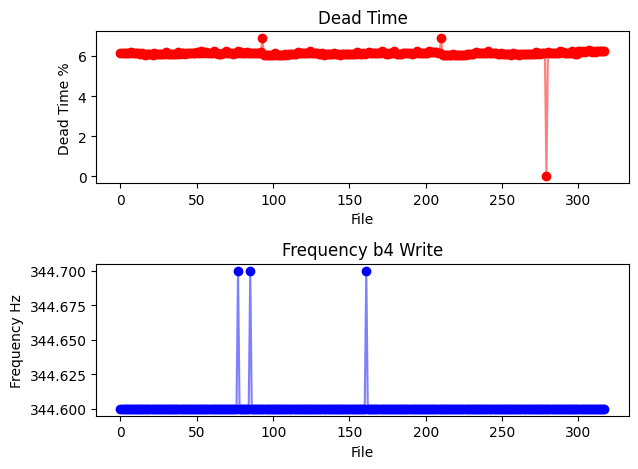

In [ ]:
import matplotlib.pyplot as plt

# Create subplots
df = df_20_100
x = df.columns
y1 = df.loc['dead_time_percent']
y2 = df.loc['freq_b4_write']

fig, (ax1, ax2) = plt.subplots(2)
# Plot dead time as scatter plot
ax1.scatter(x, y1, color='red')
ax1.plot(x, y1, color='red',alpha = 0.5)
ax1.set_title('Dead Time')
ax1.set_xlabel('File')
ax1.set_ylabel('Dead Time %')

# Plot frequency as scatter plot
ax2.scatter(x, y2, color='blue')
ax2.plot(x, y2, color='blue',alpha = 0.5)
ax2.set_title('Frequency b4 Write')
ax2.set_xlabel('File')
ax2.set_ylabel('Frequency Hz')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
plt.show()
df_5_0,df_5_20,df_5_50,df_5_100,
df_10_0,df_10_20,df_10_50,df_10_100,
df_15_0,df_15_20,df_15_50,df_15_100,
df_20_0,df_20_20,df_20_50,df_20_100

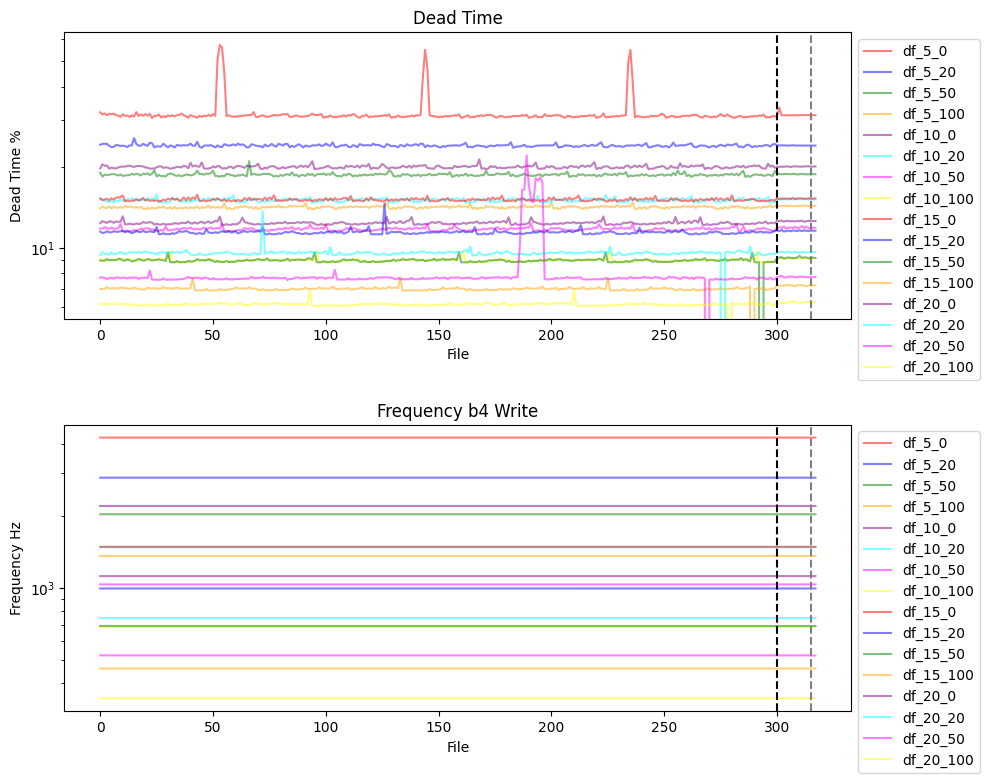

In [ ]:
import matplotlib.pyplot as plt

# Create subplots for each metric
fig, (ax1, ax2) = plt.subplots(2, figsize=(10,8))

# Define colors for each DataFrame
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow']

# Iterate over DataFrame names
for i, df_name in enumerate([
    'df_5_0', 'df_5_20', 'df_5_50', 'df_5_100',
    'df_10_0', 'df_10_20', 'df_10_50', 'df_10_100',
    'df_15_0', 'df_15_20', 'df_15_50', 'df_15_100',
    'df_20_0', 'df_20_20', 'df_20_50', 'df_20_100'
]):
    # Get the DataFrame
    df = globals()[df_name]
    
    # Extract x and y data
    x = df.columns
    y1 = df.loc['dead_time_percent']
    y2 = df.loc['freq_b4_write']
    
    # Plot dead time as scatter plot
    # ax1.scatter(x, y1, color=colors[i % len(colors)], label=f'{df_name}')
    ax1.plot(x, y1, color=colors[i % len(colors)], alpha=0.5, label=f'{df_name}')
    
    # Plot frequency as scatter plot
    # ax2.scatter(x, y2, color=colors[i % len(colors)], label=f'{df_name}')
    ax2.plot(x, y2, color=colors[i % len(colors)], alpha=0.5, label=f'{df_name}')

# Set titles and labels
ax1.set_title('Dead Time')
ax1.set_xlabel('File')
ax1.set_ylabel('Dead Time %')
ax2.set_title('Frequency b4 Write')
ax2.set_xlabel('File')
ax2.set_ylabel('Frequency Hz')

# Add vertical lines
ax1.axvline(x=300, color='black', linestyle='--')
ax1.axvline(x=315, color='gray', linestyle='--')
ax2.axvline(x=300, color='black', linestyle='--')
ax2.axvline(x=315, color='gray', linestyle='--')

# Set y-axis to logarithmic scale
ax1.set_yscale('log')
ax2.set_yscale('log')

# Add legends
ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax2.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


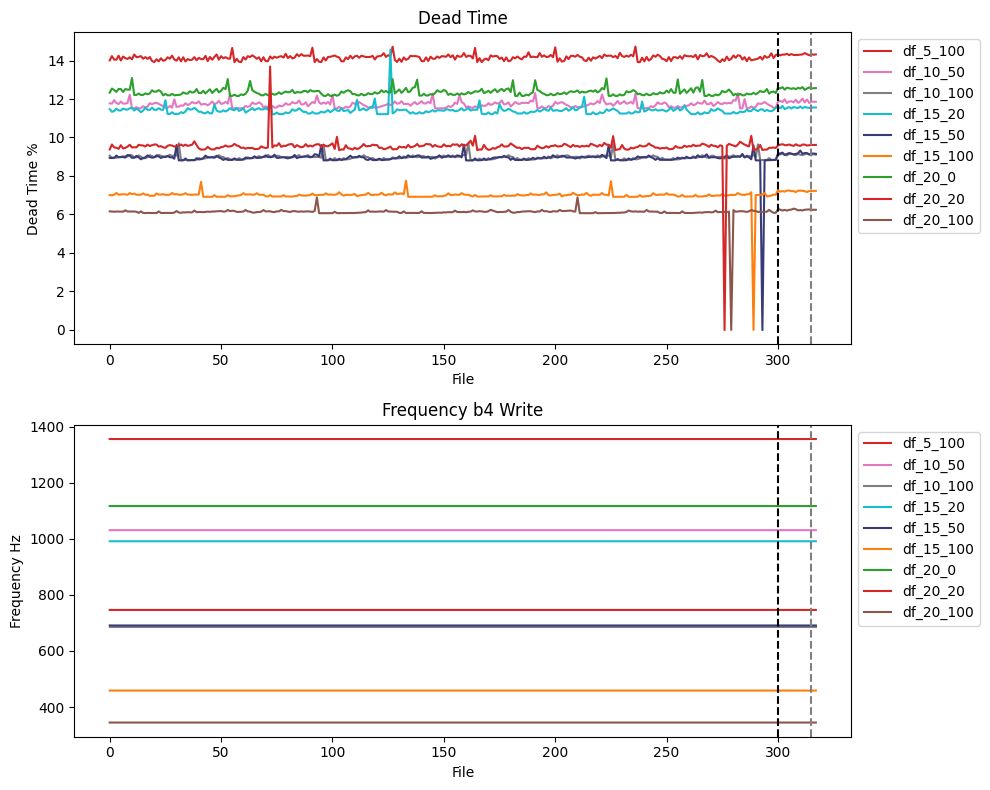

In [ ]:
import matplotlib.pyplot as plt

# Create subplots for each metric
fig, (ax1, ax2) = plt.subplots(2, figsize=(10,8))

# Define colors for each DataFrame
# colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#393b79', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']


# Iterate over DataFrame names
for i, df_name in enumerate([
    'df_5_0', 'df_5_20', 'df_5_50', 'df_5_100',
    'df_10_0', 'df_10_20', 'df_10_50', 'df_10_100',
    'df_15_0', 'df_15_20', 'df_15_50', 'df_15_100',
    'df_20_0', 'df_20_20', 'df_20_50', 'df_20_100'
]):
    # Get the DataFrame
    df = globals()[df_name]

    # Filter based on condition
    # condition = (df.loc['dead_time_percent'] > 10) | (df.loc['freq_b4_write'] < 1000)
    # condition = (df.loc['dead_time_percent'] > 10) & (df.loc['freq_b4_write'] < 1000)
    condition = (df.loc['dead_time_percent'] > 15)
    
    # Skip if the condition is met
    if condition.any():
        continue
    
    # Extract x and y data
    x = df.columns
    y1 = df.loc['dead_time_percent']
    y2 = df.loc['freq_b4_write']
    
    # Plot dead time as scatter plot
    # ax1.scatter(x, y1, color=colors[i % len(colors)], label=f'{df_name}')
    ax1.plot(x, y1, color=colors[i % len(colors)], label=f'{df_name}')
    
    # Plot frequency as scatter plot
    # ax2.scatter(x, y2, color=colors[i % len(colors)], label=f'{df_name}')
    ax2.plot(x, y2, color=colors[i % len(colors)], label=f'{df_name}')

# Set titles and labels
ax1.set_title('Dead Time')
ax1.set_xlabel('File')
ax1.set_ylabel('Dead Time %')
ax2.set_title('Frequency b4 Write')
ax2.set_xlabel('File')
ax2.set_ylabel('Frequency Hz')

# Add vertical lines
ax1.axvline(x=300, color='black', linestyle='--')
ax1.axvline(x=315, color='gray', linestyle='--')
ax2.axvline(x=300, color='black', linestyle='--')
ax2.axvline(x=315, color='gray', linestyle='--')

# Set y-axis to logarithmic scale
# ax1.set_yscale('log')
# ax2.set_yscale('log')

# Add legends
ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax2.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


# Conclusion: samples averaged = 15 delay = 20 

In [ ]:
print(df_15_20.loc['dead_time_percent'])

0       11.47
1      11.334
2      11.371
3      11.501
4      11.406
        ...  
313    11.554
314    11.535
315    11.566
316    11.559
317     11.56
Name: dead_time_percent, Length: 318, dtype: object


In [ ]:
####################################################################################################################
#                       Trial 1 struct 
# Folder: 15_20 - 3_300(300 files), 60_15(15 files), 300_3(3 files)50
# 3_300
relative_path = 'data/trial1/struct/15_20/3_300'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df1 = createDict(relative_path)
df1 = pd.DataFrame(df1).transpose()
# 60_15
relative_path = 'data/trial1/struct/15_20/60_15'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df2 = createDict(relative_path)
df2 = pd.DataFrame(df2).transpose()
# 300_3
relative_path = 'data/trial1/struct/15_20/300_3'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df3 = createDict(relative_path)
df3 = pd.DataFrame(df3).transpose()

df_s15_20 = pd.concat([df1,df2,df3], axis=1, ignore_index=True)
df_s15_20

Differences between last of one file and first of the next:
Start File:  data/trial1/struct/15_20/3_300
min:  797.1
max:  1057.6
median:  804.0
Total differences calculated:  299
Differences between last of one file and first of the next:
Start File:  data/trial1/struct/15_20/60_15
min:  803.7
max:  807.8
median:  804.55
Total differences calculated:  14
Differences between last of one file and first of the next:
Start File:  data/trial1/struct/15_20/300_3
min:  804.6
max:  806.9
median:  805.75
Total differences calculated:  2


,0,1,2,3,4,5,6,7,8,9,...,308,309,310,311,312,313,314,315,316,317
Filename,30010001.dat,30010002.dat,30010003.dat,30010004.dat,30010005.dat,30010006.dat,30010007.dat,30010008.dat,30010009.dat,30010010.dat,...,30020009.dat,30020010.dat,30020011.dat,30020012.dat,30020013.dat,30020014.dat,30020015.dat,30030001.dat,30030002.dat,30030003.dat
PARAMS_us,---,---,---,---,---,---,---,---,---,---,...,---,---,---,---,---,---,---,---,---,---
sample_delay,20,20,20,20,20,20,20,20,20,20,...,20,20,20,20,20,20,20,20,20,20
average_delay,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
samples_averaged,15,15,15,15,15,15,15,15,15,15,...,15,15,15,15,15,15,15,15,15,15
tot_samples,2586,2592,2592,2589,2591,2592,2588,2590,2591,2591,...,51763,51727,51734,51752,51680,51707,51745,258592,256146,258581
INTRA_us,---,---,---,---,---,---,---,---,---,---,...,---,---,---,---,---,---,---,---,---,---
expected_intra,300,300,300,300,300,300,300,300,300,300,...,300,300,300,300,300,300,300,300,300,300
actual_intra,1046.0,1046.0,1046.0,1046.0,1046.0,1046.0,1046.0,1046.0,1045.0,1046.0,...,1046.0,1046.0,1046.0,1046.0,1046.0,1046.0,1046.0,1046.0,1046.0,1046.0
actual_intra_dt,1061.0,1061.0,1061.0,1061.0,1061.0,1061.0,1061.0,1061.0,1061.0,1061.0,...,1061.0,1061.0,1061.0,1061.0,1061.0,1061.0,1061.0,1061.0,1061.0,1061.0


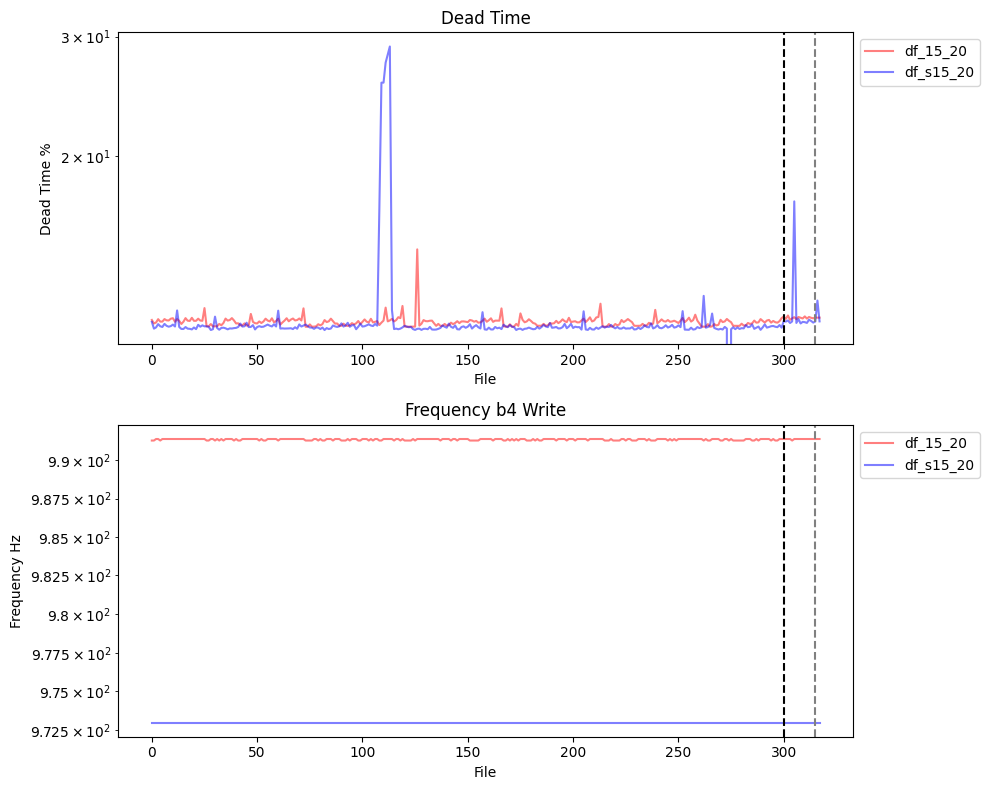

In [ ]:
import matplotlib.pyplot as plt

# Create subplots for each metric
fig, (ax1, ax2) = plt.subplots(2, figsize=(10,8))

# Define colors for each DataFrame
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow']

# Iterate over DataFrame names
for i, df_name in enumerate([
    'df_15_20', 'df_s15_20',
]):
    # Get the DataFrame
    df = globals()[df_name]
    
    # Extract x and y data
    x = df.columns
    y1 = df.loc['dead_time_percent']
    y2 = df.loc['freq_b4_write']
    
    # Plot dead time as scatter plot
    # ax1.scatter(x, y1, color=colors[i % len(colors)], label=f'{df_name}')
    ax1.plot(x, y1, color=colors[i % len(colors)], alpha=0.5, label=f'{df_name}')
    
    # Plot frequency as scatter plot
    # ax2.scatter(x, y2, color=colors[i % len(colors)], label=f'{df_name}')
    ax2.plot(x, y2, color=colors[i % len(colors)], alpha=0.5, label=f'{df_name}')

# Set titles and labels
ax1.set_title('Dead Time')
ax1.set_xlabel('File')
ax1.set_ylabel('Dead Time %')
ax2.set_title('Frequency b4 Write')
ax2.set_xlabel('File')
ax2.set_ylabel('Frequency Hz')

# Add vertical lines
ax1.axvline(x=300, color='black', linestyle='--')
ax1.axvline(x=315, color='gray', linestyle='--')
ax2.axvline(x=300, color='black', linestyle='--')
ax2.axvline(x=315, color='gray', linestyle='--')

# Set y-axis to logarithmic scale
ax1.set_yscale('log')
ax2.set_yscale('log')

# Add legends
ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax2.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


# Conclusion: Do not use the pack command

In [3]:
####################################################################################################################
#                       Trial 2  
# Folder: sdfat - 3_300(300 files), 60_15(15 files), 300_3(3 files)50
# 3_300
relative_path = 'data/trial2/sdFat/3_300'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df1 = createDict(relative_path)
df1 = pd.DataFrame(df1).transpose()
# 60_15
relative_path = 'data/trial2/sdFat/60_15'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df2 = createDict(relative_path)
df2 = pd.DataFrame(df2).transpose()
# 300_3
relative_path = 'data/trial2/sdFat/300_3'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df3 = createDict(relative_path)
df3 = pd.DataFrame(df3).transpose()

df_sdfat = pd.concat([df1,df2,df3], axis=1, ignore_index=True)
df_sdfat

Differences between last of one file and first of the next:
Start File:  data/trial2/sdFat/3_300
min:  702.1
max:  732.5
median:  706.7
Total differences calculated:  299
Differences between last of one file and first of the next:
Start File:  data/trial2/sdFat/60_15
min:  706.9
max:  738.5
median:  707.6500000000001
Total differences calculated:  14
Differences between last of one file and first of the next:
Start File:  data/trial2/sdFat/300_3
min:  708.6
max:  711.1
median:  709.85
Total differences calculated:  2


,0,1,2,3,4,5,6,7,8,9,...,308,309,310,311,312,313,314,315,316,317
Filename,30040001.dat,30040002.dat,30040003.dat,30040004.dat,30040005.dat,30040006.dat,30040007.dat,30040008.dat,30040009.dat,30040010.dat,...,30050009.dat,30050010.dat,30050011.dat,30050012.dat,30050013.dat,30050014.dat,30050015.dat,30060001.dat,30060002.dat,30060003.dat
PARAMS_us,---,---,---,---,---,---,---,---,---,---,...,---,---,---,---,---,---,---,---,---,---
sample_delay,20,20,20,20,20,20,20,20,20,20,...,20,20,20,20,20,20,20,20,20,20
average_delay,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
samples_averaged,15,15,15,15,15,15,15,15,15,15,...,15,15,15,15,15,15,15,15,15,15
tot_samples,2656,2659,2658,2656,2659,2659,2658,2661,2660,2658,...,53122,53090,53134,53127,53114,53124,53088,265504,265401,262856
INTRA_us,---,---,---,---,---,---,---,---,---,---,...,---,---,---,---,---,---,---,---,---,---
expected_intra,300,300,300,300,300,300,300,300,300,300,...,300,300,300,300,300,300,300,300,300,300
actual_intra,1026.0,1026.0,1026.0,1026.0,1026.0,1026.0,1026.0,1026.0,1026.0,1026.0,...,1026.0,1026.0,1026.0,1026.0,1026.0,1026.0,1026.0,1026.0,1026.0,1026.0
actual_intra_dt,1040.0,1040.5,1040.0,1040.0,1040.0,1040.0,1040.0,1040.0,1040.0,1040.0,...,1040.0,1040.0,1040.0,1040.0,1040.0,1040.0,1040.0,1040.0,1040.0,1040.0


In [4]:
####################################################################################################################
#                       Trial 2  
# Folder: exfat - 3_300(300 files), 60_15(15 files), 300_3(3 files)50
# 3_300
relative_path = 'data/trial2/exfat/3_300'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df1 = createDict(relative_path)
df1 = pd.DataFrame(df1).transpose()
# 60_15
relative_path = 'data/trial2/exfat/60_15'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df2 = createDict(relative_path)
df2 = pd.DataFrame(df2).transpose()
# 300_3
relative_path = 'data/trial2/exfat/300_3'
paths = get_relative_paths(relative_path)
fsls = inter_file_diff(relative_path)
df3 = createDict(relative_path)
df3 = pd.DataFrame(df3).transpose()

df_exfat = pd.concat([df1,df2,df3], axis=1, ignore_index=True)
df_exfat

Differences between last of one file and first of the next:
Start File:  data/trial2/exfat/3_300
min:  699.7
max:  749.9
median:  700.5
Total differences calculated:  299
Differences between last of one file and first of the next:
Start File:  data/trial2/exfat/60_15
min:  700.8
max:  726.4
median:  701.3
Total differences calculated:  14
Differences between last of one file and first of the next:
Start File:  data/trial2/exfat/300_3
min:  701.2
max:  701.3
median:  701.25
Total differences calculated:  2


,0,1,2,3,4,5,6,7,8,9,...,308,309,310,311,312,313,314,315,316,317
Filename,30070001.dat,30070002.dat,30070003.dat,30070004.dat,30070005.dat,30070006.dat,30070007.dat,30070008.dat,30070009.dat,30070010.dat,...,30090009.dat,30090010.dat,30090011.dat,30090012.dat,30090013.dat,30090014.dat,30090015.dat,30100001.dat,30100002.dat,30100003.dat
PARAMS_us,---,---,---,---,---,---,---,---,---,---,...,---,---,---,---,---,---,---,---,---,---
sample_delay,20,20,20,20,20,20,20,20,20,20,...,20,20,20,20,20,20,20,20,20,20
average_delay,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
samples_averaged,15,15,15,15,15,15,15,15,15,15,...,15,15,15,15,15,15,15,15,15,15
tot_samples,2759,2760,2760,2760,2760,2760,2760,2760,2760,2760,...,55175,55152,55174,55175,55175,55175,55151,275841,275791,275845
INTRA_us,---,---,---,---,---,---,---,---,---,---,...,---,---,---,---,---,---,---,---,---,---
expected_intra,300,300,300,300,300,300,300,300,300,300,...,300,300,300,300,300,300,300,300,300,300
actual_intra,1018.0,1018.0,1018.0,1018.0,1018.0,1018.0,1018.0,1018.0,1018.0,1018.0,...,1018.0,1018.0,1018.0,1018.0,1018.0,1018.0,1018.0,1018.0,1018.0,1018.0
actual_intra_dt,1032.5,1032.5,1032.5,1032.5,1032.5,1033.0,1032.5,1032.5,1032.5,1032.5,...,1032.5,1032.5,1032.5,1032.5,1032.5,1032.5,1032.5,1032.5,1032.5,1032.5


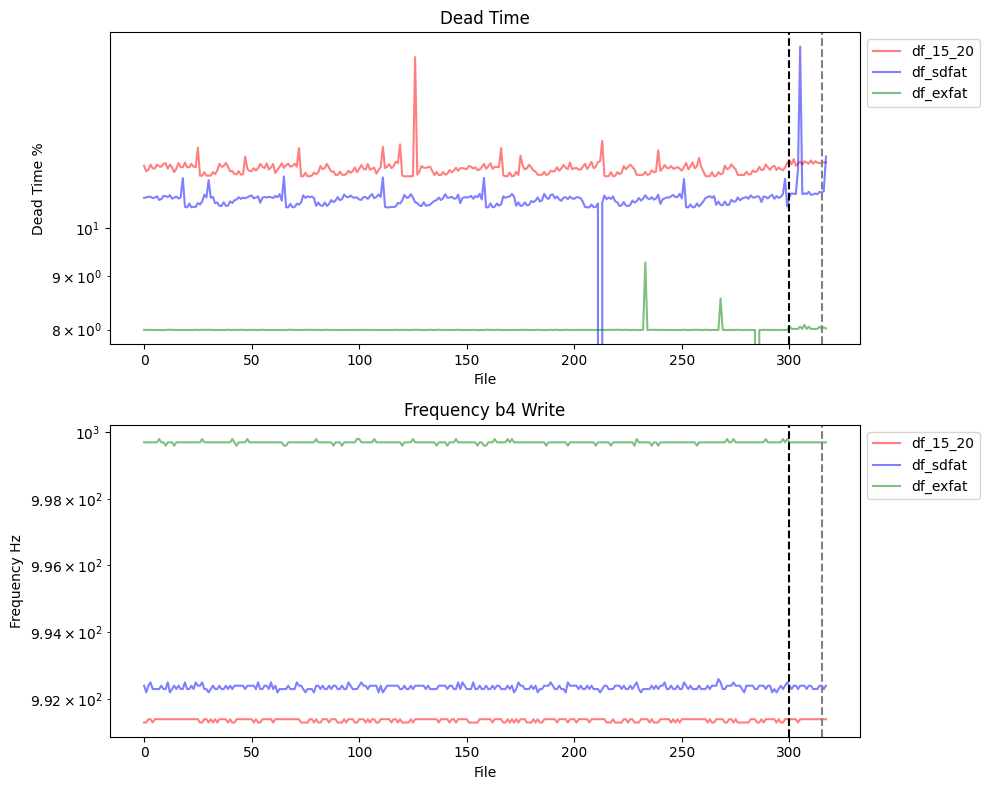

In [5]:
import matplotlib.pyplot as plt

# Create subplots for each metric
fig, (ax1, ax2) = plt.subplots(2, figsize=(10,8))

# Define colors for each DataFrame
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow']

# Iterate over DataFrame names
for i, df_name in enumerate([
    'df_15_20', 'df_sdfat', 'df_exfat'
]):
    # Get the DataFrame
    df = globals()[df_name]
    
    # Extract x and y data
    x = df.columns
    y1 = df.loc['dead_time_percent']
    y2 = df.loc['freq_b4_write']
    
    # Plot dead time as scatter plot
    # ax1.scatter(x, y1, color=colors[i % len(colors)], label=f'{df_name}')
    ax1.plot(x, y1, color=colors[i % len(colors)], alpha=0.5, label=f'{df_name}')
    
    # Plot frequency as scatter plot
    # ax2.scatter(x, y2, color=colors[i % len(colors)], label=f'{df_name}')
    ax2.plot(x, y2, color=colors[i % len(colors)], alpha=0.5, label=f'{df_name}')

# Set titles and labels
ax1.set_title('Dead Time')
ax1.set_xlabel('File')
ax1.set_ylabel('Dead Time %')
ax2.set_title('Frequency b4 Write')
ax2.set_xlabel('File')
ax2.set_ylabel('Frequency Hz')

# Add vertical lines
ax1.axvline(x=300, color='black', linestyle='--')
ax1.axvline(x=315, color='gray', linestyle='--')
ax2.axvline(x=300, color='black', linestyle='--')
ax2.axvline(x=315, color='gray', linestyle='--')

# Set y-axis to logarithmic scale
ax1.set_yscale('log')
ax2.set_yscale('log')

# Add legends
ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax2.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()
